# Giesekus LAOS: Large-Amplitude Oscillatory Shear

## Protocol Overview: Large-Amplitude Oscillatory Shear (LAOS)

In LAOS, we apply a sinusoidal strain γ(t) = γ₀ sin(ωt) where γ₀ is **large** (typically 0.1 to 10), probing the nonlinear viscoelastic regime. The stress response is no longer sinusoidal — it contains **higher harmonics**:

$$
\sigma(t) = \gamma_0 \sum_{n=1,3,5,...} [G'_n \sin(n\omega t) + G''_n \cos(n\omega t)]
$$

Only **odd harmonics** (n = 1, 3, 5, ...) appear due to the symmetry of shear flow. Even harmonics indicate asymmetry or experimental artifacts.

**Key physics for Giesekus:**  
The quadratic α·τ·τ term generates odd harmonics when the strain amplitude is large. The stress becomes a nonlinear function of strain and strain rate, producing:
- **Third harmonic** I₃ (primary nonlinearity measure)
- **Fifth harmonic** I₅ (higher-order nonlinearity)
- **Lissajous distortion** (deviation from ellipse)

**Key LAOS metrics:**
- **I₁**: Fundamental amplitude (linear response)
- **I₃/I₁**: Third harmonic ratio (nonlinearity onset, typically 1-10%)
- **I₅/I₁**: Fifth harmonic ratio (strong nonlinearity)
- **Q₀ = I₃/(I₁·γ₀²)**: Intrinsic nonlinearity (strain-amplitude independent in MAOS regime)

**Lissajous curves:**
- **Elastic Lissajous** (σ vs γ): tilted ellipse in linear regime → distorted/S-shaped in LAOS
- **Viscous Lissajous** (σ vs γ̇): rotated view, complementary information

Higher α → stronger third harmonic → more pronounced Lissajous distortion.

## Learning Objectives

1. Generate synthetic LAOS data from calibrated Giesekus parameters
2. Construct and interpret Lissajous-Bowditch curves (σ vs γ, σ vs γ̇)
3. Extract Fourier harmonics (I₁, I₃, I₅) from stress response via FFT
4. Understand how Weissenberg number Wi = λω affects nonlinearity
5. Observe the effect of α on LAOS signatures (harmonics and Lissajous distortion)

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- NB 01: Giesekus flow curve (provides calibrated parameters)

## Estimated Runtime

- **Fast demo**: ~5-10 minutes (ODE integration is slower for oscillatory protocols)
- **Full run**: ~20-30 minutes (includes parametric studies)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time as time_module
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import fft, fftfreq

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

# CI/demo toggle: True = fast (fewer parametric points), False = full study
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Large-Amplitude Oscillatory Shear

### The Experiment

In LAOS, we apply a sinusoidal strain:
$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

where γ₀ is the strain amplitude (typically 0.1 to 10) and ω is the angular frequency.

### Linear vs Nonlinear Response

**SAOS (Small Amplitude):** For γ₀ << 1, the stress is sinusoidal:
$$
\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]
$$

**LAOS (Large Amplitude):** For γ₀ ~ O(1), higher harmonics appear:
$$
\sigma(t) = \gamma_0 \sum_{n=1,3,5,...} [G'_n \sin(n\omega t) + G''_n \cos(n\omega t)]
$$

Only **odd harmonics** appear due to symmetry.

### Key LAOS Metrics

| Metric | Definition | Physical Meaning |
|--------|------------|------------------|
| I₁ | Fundamental amplitude | Linear response |
| I₃/I₁ | Third harmonic ratio | Nonlinearity onset |
| I₅/I₁ | Fifth harmonic ratio | Strong nonlinearity |
| Q₀ | I₃/(I₁·γ₀²) | Intrinsic nonlinearity |

### Lissajous-Bowditch Curves

- **Elastic Lissajous**: σ vs γ (tilted ellipse in linear regime)
- **Viscous Lissajous**: σ vs γ̇ (rotated view)

Deviation from ellipse indicates nonlinearity.

### Giesekus LAOS

The quadratic τ·τ term generates odd harmonics. Higher α leads to:
- Stronger third harmonic I₃
- More pronounced Lissajous distortion

## 3. Load Calibrated Parameters

In [3]:
# Parameters for LAOS demonstration
# We use physically reasonable defaults for ODE-based demonstrations.
# NB01 flow curve parameters can have very large λ (thousands of seconds)
# which makes ODE integration infeasible for LAOS simulations.
calibrated_params = {
    "eta_p": 100.0,
    "lambda_1": 1.0,
    "alpha": 0.3,
    "eta_s": 10.0,
}
print("LAOS demonstration parameters:")
for k, v in calibrated_params.items():
    print(f"  {k}: {v:.4g}")

lambda_1 = calibrated_params["lambda_1"]
alpha = calibrated_params["alpha"]

LAOS demonstration parameters:
  eta_p: 100
  lambda_1: 1
  alpha: 0.3
  eta_s: 10


## 4. Generate Synthetic LAOS Data

In [4]:
# Create model with calibrated parameters
model = GiesekusSingleMode()
for name, val in calibrated_params.items():
    model.parameters.set_value(name, val)

# LAOS parameters
gamma_0 = 1.0  # Strain amplitude (large)
omega = 1.0    # Angular frequency (rad/s)
n_cycles = 10  # Number of oscillation cycles
n_points_per_cycle = 100

# Dimensionless numbers
Wi = lambda_1 * omega
De = lambda_1 * gamma_0 * omega  # Deborah number

print(f"LAOS parameters:")
print(f"  γ₀ = {gamma_0} (strain amplitude)")
print(f"  ω = {omega} rad/s")
print(f"  Wi = λω = {Wi:.2f}")
print(f"  De = λγ₀ω = {De:.2f}")

LAOS parameters:
  γ₀ = 1.0 (strain amplitude)
  ω = 1.0 rad/s
  Wi = λω = 1.00
  De = λγ₀ω = 1.00


In [5]:
# Generate time array
period = 2 * np.pi / omega
t_end = n_cycles * period
n_total = n_cycles * n_points_per_cycle
time = np.linspace(0.01, t_end, n_total)

# Compute strain and strain rate
strain = gamma_0 * np.sin(omega * time)
strain_rate = gamma_0 * omega * np.cos(omega * time)

# Simulate LAOS stress
print("Simulating LAOS response (this may take a moment)...")
t0 = time_module.time()
result = model.simulate_laos(time, gamma_0=gamma_0, omega=omega, n_cycles=n_cycles)
t_sim = time_module.time() - t0
print(f"Simulation time: {t_sim:.1f} s")

# Extract stress
if isinstance(result, dict):
    stress = np.array(result.get("stress", result.get("sigma", np.zeros_like(time))))
else:
    stress = np.array(result)

# Ensure same length
if len(stress) != len(time):
    stress = np.interp(time, np.linspace(0, t_end, len(stress)), stress)

Simulating LAOS response (this may take a moment)...


Simulation time: 1.1 s


In [6]:
# Add noise (3%)
rng = np.random.default_rng(42)
noise_level = 0.03
noise = rng.normal(0, noise_level * np.std(stress), size=stress.shape)
stress_noisy = stress + noise

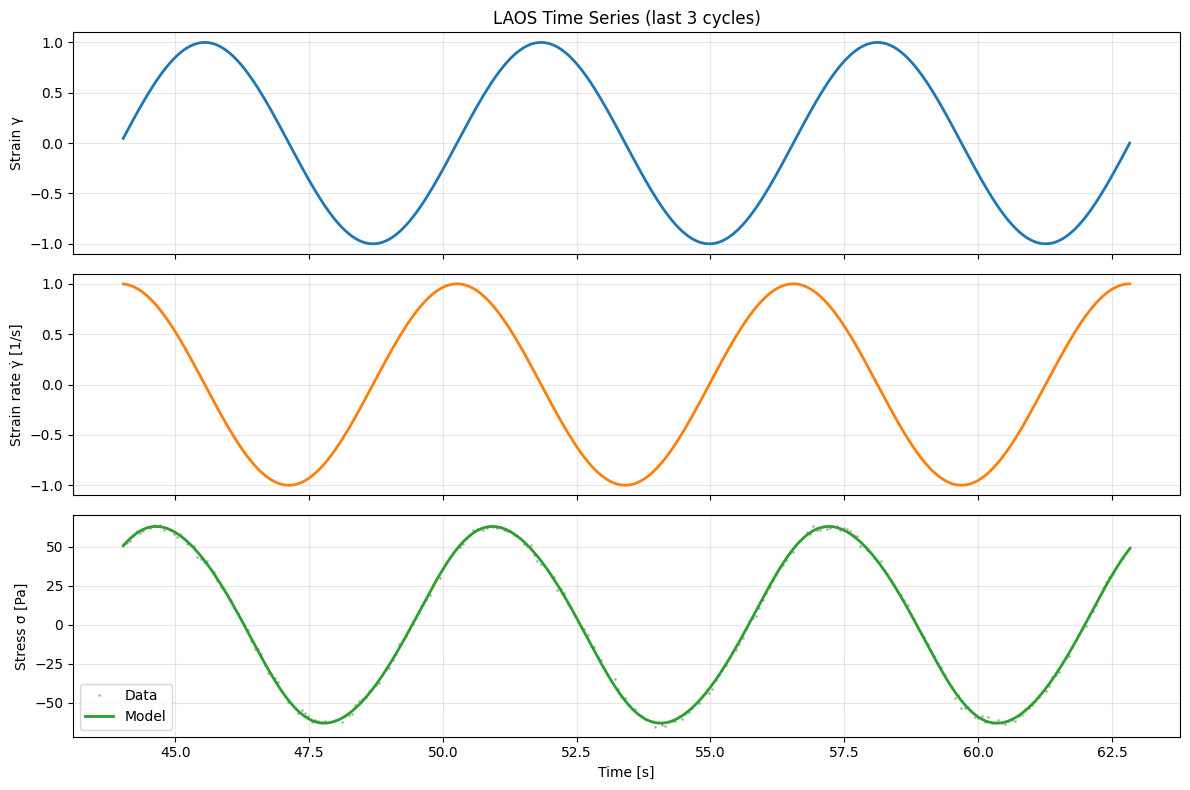

In [7]:
# Plot time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Last 3 cycles for clarity
t_start = (n_cycles - 3) * period
mask = time >= t_start

axes[0].plot(time[mask], strain[mask], "-", lw=2, color="C0")
axes[0].set_ylabel("Strain γ")
axes[0].set_title("LAOS Time Series (last 3 cycles)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(time[mask], strain_rate[mask], "-", lw=2, color="C1")
axes[1].set_ylabel("Strain rate γ̇ [1/s]")
axes[1].grid(True, alpha=0.3)

axes[2].plot(time[mask], stress_noisy[mask], ".", markersize=2, color="gray", alpha=0.5, label="Data")
axes[2].plot(time[mask], stress[mask], "-", lw=2, color="C2", label="Model")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Stress σ [Pa]")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Lissajous-Bowditch Curves

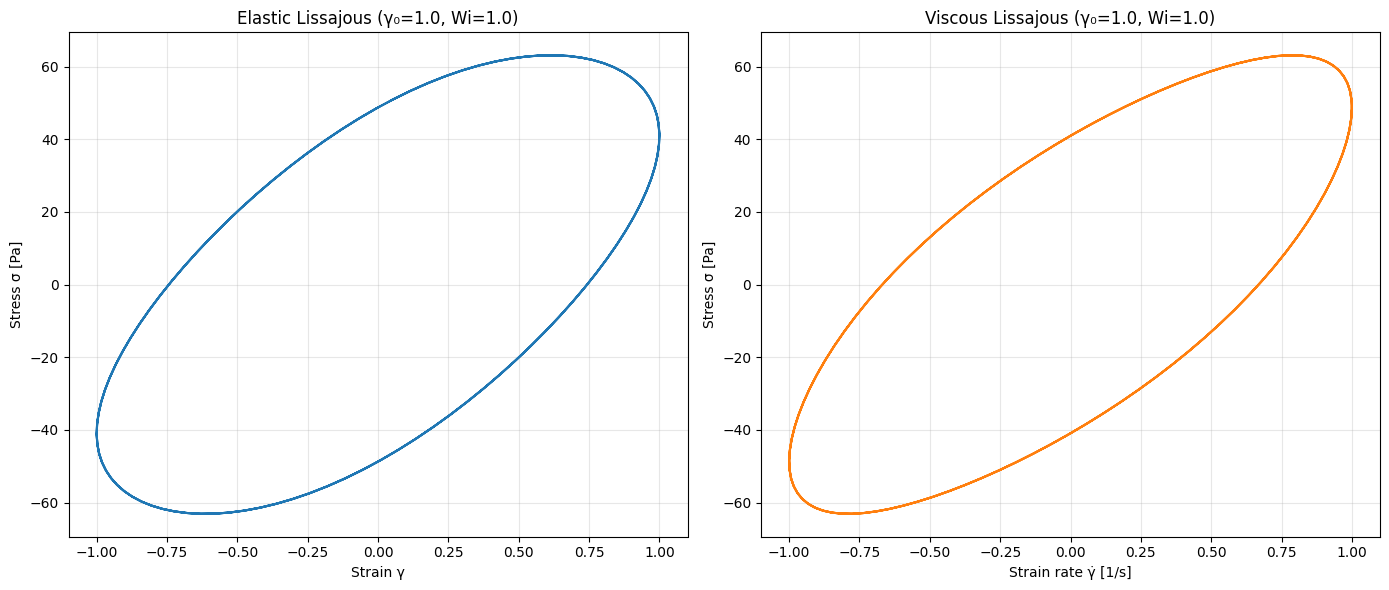

Lissajous interpretation:
  - Perfect ellipse = linear viscoelastic
  - Deviation from ellipse = nonlinear response
  - S-shape or figure-8 = strong nonlinearity


In [8]:
# Use steady-state cycles (last 3)
t_ss = (n_cycles - 3) * period
mask_ss = time >= t_ss

strain_ss = strain[mask_ss]
strain_rate_ss = strain_rate[mask_ss]
stress_ss = stress[mask_ss]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Lissajous: σ vs γ
ax1.plot(strain_ss, stress_ss, "-", lw=1.5, color="C0")
ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"Elastic Lissajous (γ₀={gamma_0}, Wi={Wi:.1f})")
ax1.grid(True, alpha=0.3)
ax1.set_aspect("auto")

# Viscous Lissajous: σ vs γ̇
ax2.plot(strain_rate_ss, stress_ss, "-", lw=1.5, color="C1")
ax2.set_xlabel("Strain rate γ̇ [1/s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title(f"Viscous Lissajous (γ₀={gamma_0}, Wi={Wi:.1f})")
ax2.grid(True, alpha=0.3)
ax2.set_aspect("auto")

plt.tight_layout()
display(fig)
plt.close(fig)

print("Lissajous interpretation:")
print("  - Perfect ellipse = linear viscoelastic")
print("  - Deviation from ellipse = nonlinear response")
print("  - S-shape or figure-8 = strong nonlinearity")

## 6. Fourier Harmonic Extraction

In [9]:
# Extract harmonics from one steady-state cycle
cycle_start = (n_cycles - 1) * n_points_per_cycle
cycle_end = n_cycles * n_points_per_cycle
stress_cycle = stress[cycle_start:cycle_end]
time_cycle = time[cycle_start:cycle_end] - time[cycle_start]

# FFT
n = len(stress_cycle)
stress_fft = fft(stress_cycle)
freqs = fftfreq(n, d=(time_cycle[1] - time_cycle[0]))

# Find fundamental frequency index
fundamental_freq = omega / (2 * np.pi)
freq_idx = np.argmin(np.abs(freqs - fundamental_freq))

# Extract harmonics
I1 = 2 * np.abs(stress_fft[freq_idx]) / n
I3_idx = np.argmin(np.abs(freqs - 3 * fundamental_freq))
I3 = 2 * np.abs(stress_fft[I3_idx]) / n
I5_idx = np.argmin(np.abs(freqs - 5 * fundamental_freq))
I5 = 2 * np.abs(stress_fft[I5_idx]) / n

print("Fourier Harmonics")
print("=" * 40)
print(f"I₁ (fundamental):  {I1:.4f} Pa")
print(f"I₃ (3rd harmonic): {I3:.4f} Pa")
print(f"I₅ (5th harmonic): {I5:.4f} Pa")
print(f"\nI₃/I₁: {I3/I1:.4f} ({100*I3/I1:.2f}%)")
print(f"I₅/I₁: {I5/I1:.4f} ({100*I5/I1:.2f}%)")

Fourier Harmonics
I₁ (fundamental):  63.1861 Pa
I₃ (3rd harmonic): 1.1097 Pa
I₅ (5th harmonic): 0.0186 Pa

I₃/I₁: 0.0176 (1.76%)
I₅/I₁: 0.0003 (0.03%)


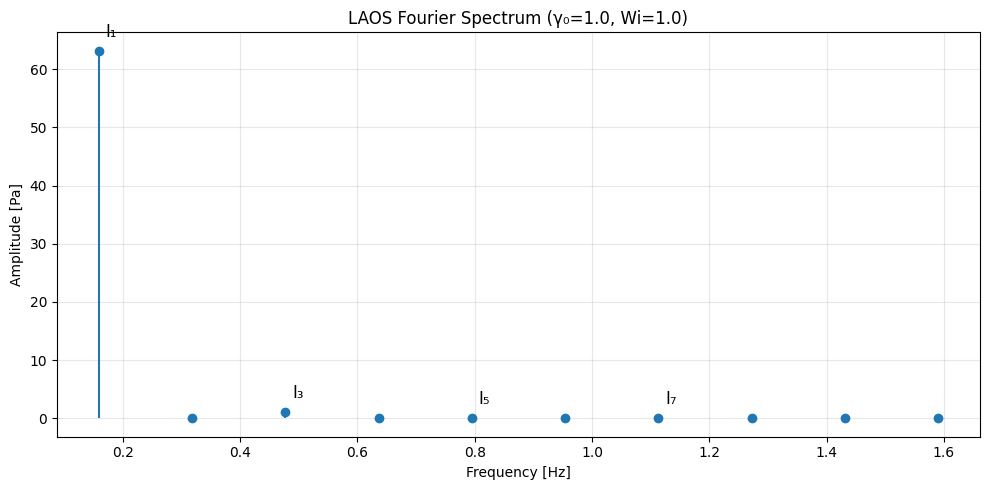

In [10]:
# Plot FFT spectrum
fig, ax = plt.subplots(figsize=(10, 5))

# Only positive frequencies up to 10th harmonic
max_freq = 10 * fundamental_freq
pos_mask = (freqs > 0) & (freqs < max_freq)

amplitudes = 2 * np.abs(stress_fft) / n

ax.stem(freqs[pos_mask], amplitudes[pos_mask], basefmt=" ")

# Mark harmonics
for h, label in [(1, "I₁"), (3, "I₃"), (5, "I₅"), (7, "I₇")]:
    h_freq = h * fundamental_freq
    h_idx = np.argmin(np.abs(freqs - h_freq))
    ax.annotate(label, (freqs[h_idx], amplitudes[h_idx]), 
                xytext=(5, 10), textcoords="offset points", fontsize=12)

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude [Pa]")
ax.set_title(f"LAOS Fourier Spectrum (γ₀={gamma_0}, Wi={Wi:.1f})")
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Effect of Strain Amplitude on Nonlinearity

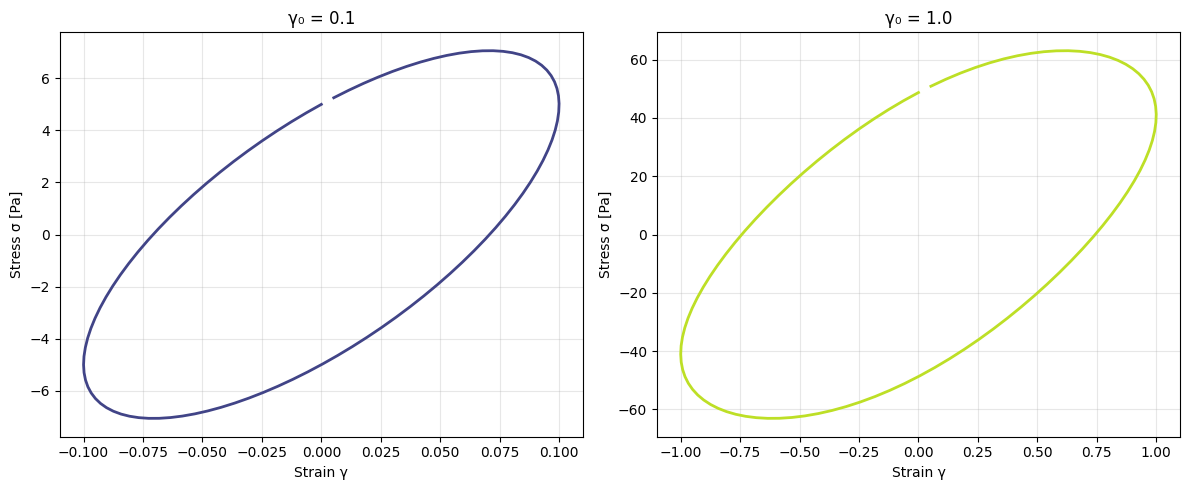


I₃/I₁ vs strain amplitude:
  γ₀ = 0.1: I₃/I₁ = 0.0008
  γ₀ = 1.0: I₃/I₁ = 0.0173


13091

In [11]:
# Compare different strain amplitudes
if FAST_MODE:
    gamma_0_values = [0.1, 1.0]
    n_cyc_study = 5
else:
    gamma_0_values = [0.1, 0.5, 1.0, 2.0]
    n_cyc_study = 5

colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gamma_0_values)))

n_cols = 2
n_rows = (len(gamma_0_values) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

I3_I1_list = []

for i, g0 in enumerate(gamma_0_values):
    # Simulate
    per = 2 * np.pi / omega
    t = np.linspace(0.01, n_cyc_study * per, n_cyc_study * 100)
    
    result_i = model.simulate_laos(t, gamma_0=g0, omega=omega, n_cycles=n_cyc_study)
    if isinstance(result_i, dict):
        stress_i = np.array(result_i.get("stress", result_i.get("sigma", np.zeros_like(t))))
    else:
        stress_i = np.array(result_i)
    if len(stress_i) != len(t):
        stress_i = np.interp(t, np.linspace(0, n_cyc_study * per, len(stress_i)), stress_i)
    
    # Strain
    strain_i = g0 * np.sin(omega * t)
    
    # Last cycle for Lissajous
    mask = t >= (n_cyc_study - 1) * per
    
    # Lissajous
    ax_row = i // n_cols
    ax_col = i % n_cols
    ax = axes[ax_row, ax_col]
    ax.plot(strain_i[mask], stress_i[mask], "-", lw=2, color=colors[i])
    ax.set_xlabel("Strain γ")
    ax.set_ylabel("Stress σ [Pa]")
    ax.set_title(f"γ₀ = {g0}")
    ax.grid(True, alpha=0.3)
    
    # FFT for I3/I1
    stress_cyc = stress_i[-100:]
    stress_fft_i = fft(stress_cyc)
    n_pts = len(stress_cyc)
    amps = 2 * np.abs(stress_fft_i) / n_pts
    I1_i = amps[1] if len(amps) > 1 else 1.0
    I3_i = amps[3] if len(amps) > 3 else 0.0
    I3_I1_list.append(I3_i / I1_i if I1_i > 0 else 0)

# Hide unused axes
for idx in range(len(gamma_0_values), n_rows * n_cols):
    axes[idx // n_cols, idx % n_cols].set_visible(False)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nI₃/I₁ vs strain amplitude:")
for g0, ratio in zip(gamma_0_values, I3_I1_list):
    print(f"  γ₀ = {g0}: I₃/I₁ = {ratio:.4f}")

gc.collect()

## 8. Effect of α on LAOS

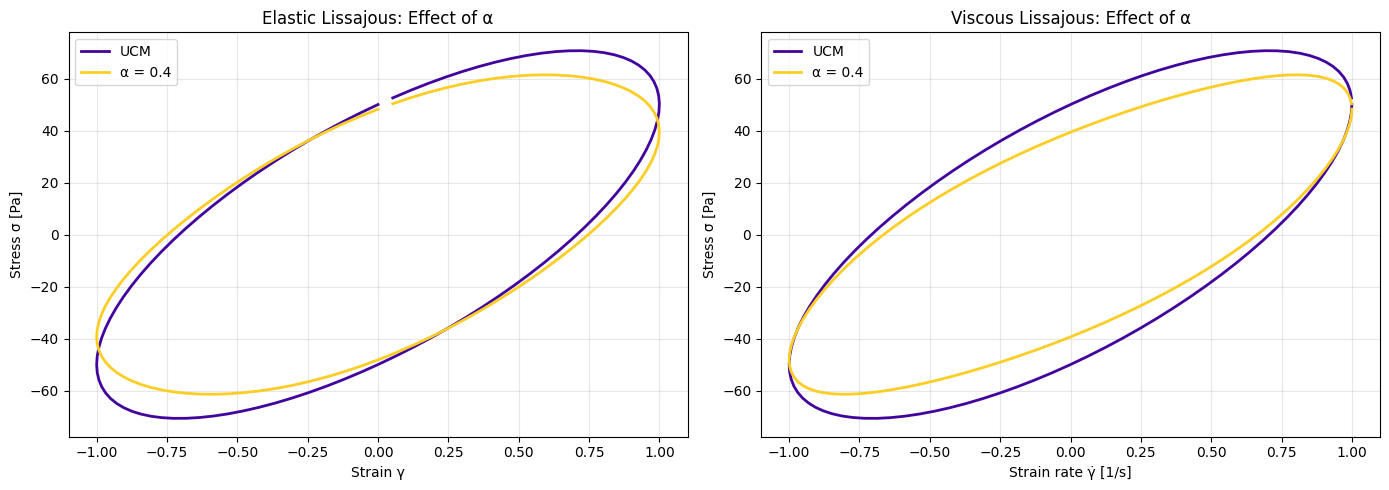

6726

In [12]:
# Compare different α values at fixed γ₀ = 1
if FAST_MODE:
    alpha_values_laos = [0.0, 0.4]
    n_cyc_alpha = 5
else:
    alpha_values_laos = [0.0, 0.2, 0.4]
    n_cyc_alpha = 5

colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(alpha_values_laos)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, alpha_i in enumerate(alpha_values_laos):
    model_i = GiesekusSingleMode()
    model_i.parameters.set_value("eta_p", calibrated_params["eta_p"])
    model_i.parameters.set_value("lambda_1", calibrated_params["lambda_1"])
    model_i.parameters.set_value("alpha", alpha_i)
    model_i.parameters.set_value("eta_s", calibrated_params["eta_s"])
    
    # Simulate
    per = 2 * np.pi / omega
    t = np.linspace(0.01, n_cyc_alpha * per, n_cyc_alpha * 100)
    
    result_i = model_i.simulate_laos(t, gamma_0=1.0, omega=omega, n_cycles=n_cyc_alpha)
    if isinstance(result_i, dict):
        stress_i = np.array(result_i.get("stress", result_i.get("sigma", np.zeros_like(t))))
    else:
        stress_i = np.array(result_i)
    if len(stress_i) != len(t):
        stress_i = np.interp(t, np.linspace(0, n_cyc_alpha * per, len(stress_i)), stress_i)
    
    strain_i = 1.0 * np.sin(omega * t)
    strain_rate_i = 1.0 * omega * np.cos(omega * t)
    
    mask = t >= (n_cyc_alpha - 1) * per
    
    label = "UCM" if alpha_i == 0 else f"α = {alpha_i}"
    ax1.plot(strain_i[mask], stress_i[mask], "-", lw=2, color=colors[i], label=label)
    ax2.plot(strain_rate_i[mask], stress_i[mask], "-", lw=2, color=colors[i], label=label)

ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title("Elastic Lissajous: Effect of α")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Strain rate γ̇ [1/s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Viscous Lissajous: Effect of α")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

gc.collect()

## 9. Save Results

In [13]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "laos")
os.makedirs(output_dir, exist_ok=True)

# Save LAOS parameters and harmonics
laos_results = {
    "gamma_0": float(gamma_0),
    "omega": float(omega),
    "Wi": float(Wi),
    "De": float(De),
    "I1": float(I1),
    "I3": float(I3),
    "I5": float(I5),
    "I3_I1": float(I3 / I1),
    "I5_I1": float(I5 / I1),
    "alpha": float(alpha),
}
with open(os.path.join(output_dir, "laos_harmonics.json"), "w") as f:
    json.dump(laos_results, f, indent=2)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/laos/


## Key Takeaways

1. **LAOS probes nonlinear viscoelasticity** through higher harmonics and Lissajous distortion. It reveals intracycle nonlinearity that cannot be seen in steady shear or SAOS.

2. **Odd harmonics** (I₃, I₅, I₇, ...) arise from material nonlinearity due to the α·τ·τ term. Even harmonics indicate asymmetry (e.g., thixotropy, yield stress) or experimental artifacts.

3. **I₃/I₁ ratio** is the primary measure of nonlinearity:
   - I₃/I₁ < 1% → linear regime (SAOS valid)
   - I₃/I₁ = 1-5% → medium amplitude (MAOS)
   - I₃/I₁ > 5% → strong nonlinearity (LAOS)

4. **α affects LAOS signatures**:
   - Higher α → stronger third harmonic I₃
   - Higher α → more pronounced Lissajous distortion (S-shape, figure-8)
   - UCM (α=0) shows weaker nonlinearity than Giesekus (α>0)

5. **Lissajous curves** provide intuitive visualization:
   - **Perfect ellipse** = linear viscoelastic (SAOS)
   - **Distorted ellipse** = mild nonlinearity (MAOS)
   - **S-shape or figure-8** = strong nonlinearity (LAOS)

### LAOS Analysis Methods

| Method | What It Measures | Key Output |
|--------|------------------|------------|
| **Fourier Transform (FT)** | Harmonic amplitudes | I₁, I₃, I₅, ... |
| **Chebyshev decomposition** | Elastic/viscous split | e₁, v₁, e₃, v₃ |
| **SPP (Sequence of Physical Processes)** | Time-resolved moduli | G'_M(t), G''_M(t) |
| **Lissajous-Bowditch** | Visual fingerprint | Shape distortion |

### Pipkin Diagram: De vs Wi

LAOS behavior is mapped in the **Pipkin diagram** (De = λγ₀ω vs Wi = λω):

| De | Wi | Regime |
|----|----|----|
| ≪ 1 | Any | Linear viscoelastic (SAOS) |
| ≫ 1 | ≪ 1 | Quasi-steady nonlinear (flow curve-like) |
| ≫ 1 | ≫ 1 | Highly nonlinear viscoelastic (true LAOS) |

### This Completes the Giesekus Tutorial Suite!

You have now covered all 6 rheological protocols for the Giesekus model:

1. **Flow curve** (NB01) — Steady shear, α from shear-thinning onset Wi_c ≈ 1/√α
2. **SAOS** (NB02) — Linear regime, α-independent, relaxation time λ from ω_c = 1/λ
3. **Startup** (NB03) — Stress overshoot, transient nonlinearity, α dampens overshoot
4. **Normal stresses** (NB04) — N₂/N₁ = -α/2, most direct α measurement
5. **Creep** (NB05) — Strain under constant stress, compliance J(t)
6. **Relaxation** (NB06) — Faster-than-Maxwell decay from α·τ·τ dissipation
7. **LAOS** (NB07) — Nonlinear oscillatory, odd harmonics, Lissajous distortion

### Recommended Multi-Protocol Fitting Strategy

1. **Start with SAOS** → fit η_p, λ, η_s (α unconstrained)
2. **Add flow curve** → refine η_p, λ; constrain α from thinning shape
3. **Validate with normal stresses** → fix α = -2(N₂/N₁) if N₂ data available
4. **Check transients** → startup for overshoot, relaxation for faster-than-exponential decay
5. **Verify with LAOS** → confirm α via I₃/I₁ at different γ₀

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — LAOS equations (§ Large-Amplitude Oscillatory Shear)
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — Complete protocol overview

**Key LAOS References:**
1. Hyun, K., Wilhelm, M., et al. (2011). "A review of nonlinear oscillatory shear tests: Analysis and application of LAOS." *Prog. Polym. Sci.*, 36, 1697-1753. [doi:10.1016/j.progpolymsci.2011.02.002](https://doi.org/10.1016/j.progpolymsci.2011.02.002)

2. Ewoldt, R.H., & McKinley, G.H. (2010). "On secondary loops in LAOS via self-intersection of Lissajous-Bowditch curves." *Rheol. Acta*, 49, 213-219.

3. Giesekus, H. (1982). "A simple constitutive equation for polymer fluids based on the concept of deformation-dependent tensorial mobility." *J. Non-Newtonian Fluid Mech.*, 11, 69-109.